In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Bowling Analysis (Ball By Ball)/EDA/Bowling Performance Metrics (Ball By Ball).csv')
scaled_df = pd.read_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Bowling Analysis (Ball By Ball)/EDA/Bowling Performance Metrics (Ball By Ball) - Scaled.csv')

In [ ]:
df

,Team,Player,ES,WTS,BBI,CS,BWTS,SPS,DBI,EI,AVMS,BI
0,Annfield Plain CC Under 13,Daniel Carr,0.403846,0.134615,11.800000,3.000000,0.200000,1.000000,0.634615,0.833333,3.933333,0.000000
1,Annfield Plain CC Under 13,Hayden Jackman,0.477273,0.056818,13.285714,8.400000,0.142857,0.333333,0.727273,0.347222,1.581633,0.347222
2,Annfield Plain CC Under 13,J Liddle,0.584615,0.153846,14.000000,3.800000,0.200000,1.500000,0.538462,0.476190,3.684211,0.380952
3,Annfield Plain CC Under 13,James Bennett,0.707692,0.076923,12.166667,9.200000,0.000000,0.833333,0.553846,0.761905,1.322464,0.380952
4,Annfield Plain CC Under 13,Luke Boyle,1.000000,0.027778,13.000000,36.000000,0.000000,0.285714,0.583333,1.583333,0.361111,0.416667
...,...,...,...,...,...,...,...,...,...,...,...,...
303,Shotley Bridge CC Under 13,Daniel Garside,0.865385,0.076923,13.000000,11.250000,0.000000,0.800000,0.576923,1.547619,1.155556,0.238095
304,Shotley Bridge CC Under 13,Hannah Collingwood,1.183333,0.050000,17.000000,23.666667,0.250000,0.000000,0.466667,0.800000,0.718310,0.700000
305,Shotley Bridge CC Under 13,Joshua Holmes,0.783133,0.024096,17.333333,32.500000,0.000000,0.333333,0.650602,1.555556,0.533333,0.222222
306,Ushaw Moor CC Under 13,Mason Lee,0.614035,0.070175,10.166667,8.750000,0.000000,0.666667,0.614035,0.430108,1.161905,0.430108


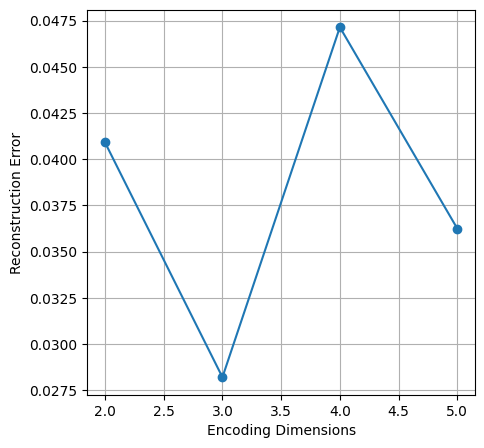

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(scaled_df, test_size=0.2, random_state=42)

encoding_dims = range(2,6)
reconstruction_errors = []

for dim in encoding_dims:
  input_dim = scaled_df.shape[1]
  input_layer = Input(shape=(input_dim,))
  encoder = Dense(dim, activation='relu')(input_layer)
  decoder = Dense(input_dim, activation='linear')(encoder)
  autoencoder = Model(input_layer, decoder)

  autoencoder.compile(optimizer='adam', loss='mean_squared_error')
  autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test, X_test), verbose=0)

  reconstruction_error = autoencoder.evaluate(X_test, X_test, verbose=0)
  reconstruction_errors.append(reconstruction_error)

plt.figure(figsize=(5, 5))
plt.plot(encoding_dims, reconstruction_errors, marker='o')
plt.xlabel('Encoding Dimensions')
plt.ylabel('Reconstruction Error')
# plt.title('Reconstruction Error vs. Encoding Dimensions')
plt.grid(True)
plt.show()

In [ ]:
optimal_dim = encoding_dims[np.argmin(reconstruction_errors)]
print(optimal_dim)

3


In [ ]:
n_features = scaled_df.shape[1]
n_features

10

In [ ]:
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

input_layer = Input(shape=(n_features,))
encoder = Dense(n_features-1)(input_layer)
encoder = LeakyReLU()(encoder)
encoder = Dense(n_features-1)(encoder)
encoder = LeakyReLU()(encoder)
encoder = Dense(n_features-1)(encoder)
encoder = LeakyReLU()(encoder)
encoder = Dense(optimal_dim)(encoder)

decoder = Dense(n_features+1)(encoder)
decoder = LeakyReLU()(decoder)
decoder = Dense(n_features+1)(decoder)
decoder = LeakyReLU()(decoder)
decoder = Dense(n_features+1)(decoder)
decoder = LeakyReLU()(decoder)
decoder = Dense(n_features, activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
encoder = Model(inputs=input_layer, outputs=encoder)
autoencoder.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

autoencoder.fit(scaled_df, scaled_df, epochs=100, batch_size=15, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

encoded_data = encoder.predict(scaled_df)

encoded_df = pd.DataFrame(encoded_data, columns=[f'ED {i+1}' for i in range(optimal_dim)])

Epoch 1/100
17/17 [==============================] - 2s 15ms/step - loss: 0.1543 - val_loss: 0.1323 - lr: 0.0010
Epoch 2/100
17/17 [==============================] - 0s 5ms/step - loss: 0.1029 - val_loss: 0.0877 - lr: 0.0010
Epoch 3/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0663 - val_loss: 0.0533 - lr: 0.0010
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0421 - val_loss: 0.0355 - lr: 0.0010
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0319 - val_loss: 0.0310 - lr: 0.0010
Epoch 6/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0296 - val_loss: 0.0307 - lr: 0.0010
Epoch 7/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0294 - val_loss: 0.0309 - lr: 0.0010
Epoch 8/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0293 - val_loss: 0.0307 - lr: 0.0010
Epoch 9/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0291 - val_loss: 0.0303 - lr

In [ ]:
encoded_df.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Bowling Analysis (Ball By Ball)/Analysis (Autoencoders)/Bowling Performance Metrics (Ball By Ball) - Encoded.csv', index=False)

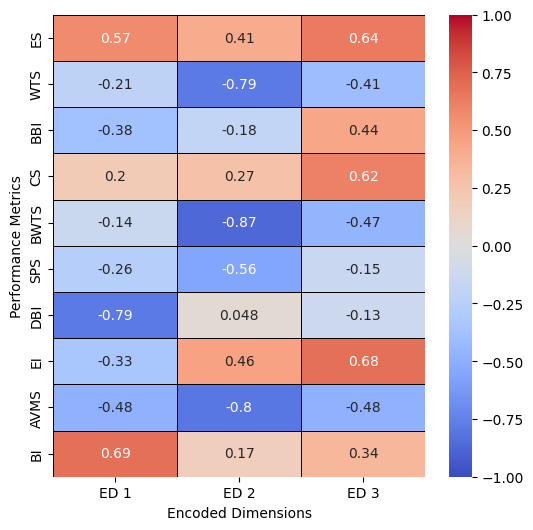

In [ ]:
correlation_matrix = scaled_df.corrwith(encoded_df, axis=0).to_frame().transpose()

# Transpose the correlation matrix for better readability
correlation_matrix = pd.concat([scaled_df.corrwith(encoded_df[col]) for col in encoded_df.columns], axis=1)
correlation_matrix.columns = encoded_df.columns

plt.figure(figsize=(6, 6))

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0, linecolor='black', linewidths=0.5)


# plt.title('Correlation Between Scaled Performance Metrics and Encoded Dimensions')
plt.xlabel('Encoded Dimensions')
plt.ylabel('Performance Metrics')

plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

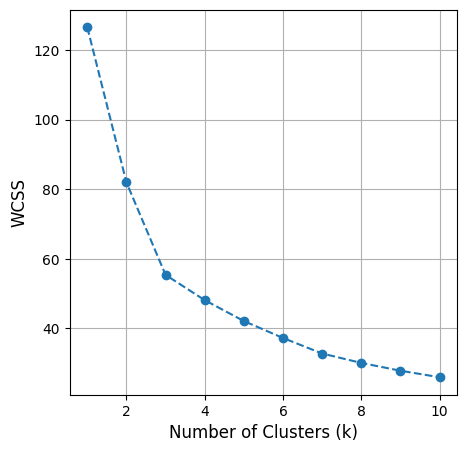

In [ ]:
from sklearn.cluster import KMeans

wcss = []
k_values = range(1,11)

for k in k_values:
  kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
  kmeans.fit(encoded_df)
  wcss.append(kmeans.inertia_)

plt.figure(figsize=(5, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('WCSS', fontsize=12)
# plt.title('Optimal Number of Clusters', fontsize=14)
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

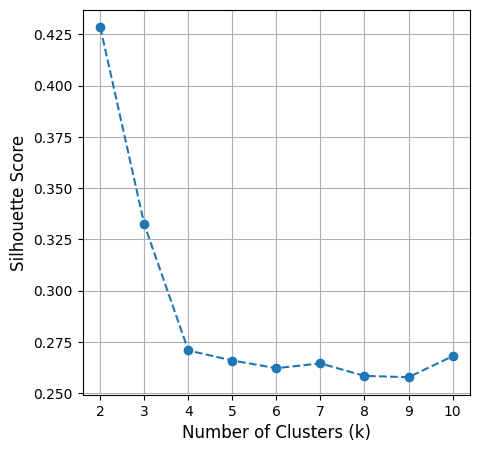

In [ ]:
from sklearn.metrics import silhouette_score

sil_scores = []

for k in k_values[1:]:
  kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
  kmeans.fit(encoded_df)
  score = silhouette_score(encoded_df, kmeans.labels_)
  sil_scores.append(score)

plt.figure(figsize=(5, 5))
plt.plot(k_values[1:], sil_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
# plt.title('Optimal Number of Clusters', fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
optimal_k = k_values[1:][np.argmax(sil_scores)]

In [ ]:
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(encoded_df)


encoded_df['KCluster'] = clusters
df['KCluster'] = clusters
scaled_df['KCluster'] = clusters



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


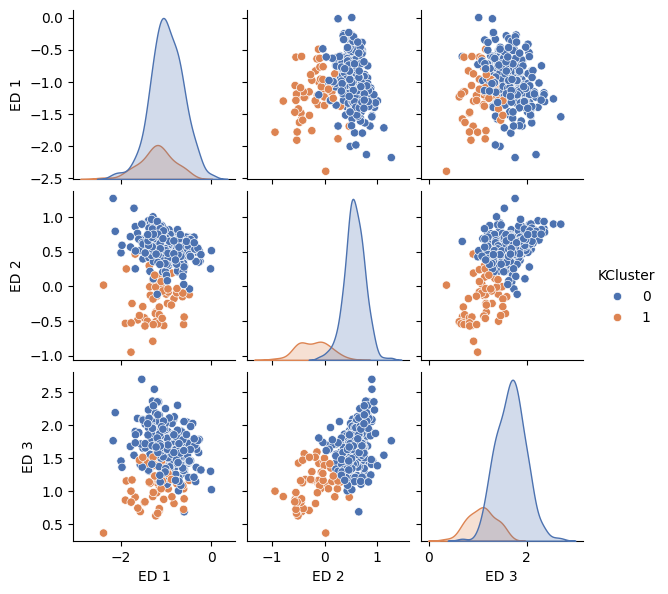

In [ ]:
sns.pairplot(encoded_df, hue='KCluster', palette='deep', diag_kind='kde', height=2, aspect=1)
# plt.suptitle('Pairplot of Encoded Dimensions', y=1.02)
plt.show()


In [ ]:
kcluster_means_summary = scaled_df.groupby('KCluster').mean()
kcluster_means_summary.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Bowling Analysis (Ball By Ball)/Analysis (Autoencoders)/KMeans (Autoencoder) - Summary.csv')
kcluster_means_summary

,ES,WTS,BBI,CS,BWTS,SPS,DBI,EI,AVMS,BI
KCluster,,,,,,,,,,
0,0.544178,0.188799,0.447782,0.580123,0.021448,0.260602,0.531141,0.405827,0.219296,0.411661
1,0.360104,0.405962,0.486818,0.409750,0.493198,0.377543,0.607409,0.272925,0.510339,0.282754


In [ ]:
kcluster_descriptive = scaled_df.groupby('KCluster').describe()
kcluster_descriptive.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Bowling Analysis (Ball By Ball)/Analysis (Autoencoders)/KMeans (Autoencoder) - Descriptive.csv')
kcluster_descriptive

ES                                                              \
          count      mean       std       min       25%       50%       75%   
KCluster                                                                      
0         254.0  0.544178  0.147403  0.170649  0.443325  0.531062  0.637890   
1          54.0  0.360104  0.131517  0.000000  0.261590  0.368937  0.468494   

                      WTS            ...      AVMS               BI            \
               max  count      mean  ...       75%       max  count      mean   
KCluster                             ...                                        
0         1.000000  254.0  0.188799  ...  0.306323  0.605743  254.0  0.411661   
1         0.626695   54.0  0.405962  ...  0.599617  1.000000   54.0  0.282754   

                                                                 
               std  min       25%       50%       75%       max  
KCluster                                                         
0         0.183144  0.0  0.285053  0.385596  0.526557  1.000000  
1         0.141774  0.0  0.199835  0.301661  0.352380  0.579719  

[2 rows x 80 columns]

In [ ]:
weights = {
    'WTS': 1,
    'CS': 1,
    'ES': 1,
    'BBI': 1,
    'BWTS': 1,
    'SPS': 1,
    'EI': 1,
    'DBI': 1,
    'AVMS': 1,
    'BI': 1
}

cluster_1_data = scaled_df[clusters==1].copy()
cluster_1_data['Composite Score'] = (
    cluster_1_data['BBI'] * weights['BBI'] +
    cluster_1_data['WTS'] * weights['WTS'] +
    cluster_1_data['CS'] * weights['CS'] +
    cluster_1_data['EI'] * weights['EI'] +
    cluster_1_data['BWTS'] * weights['BWTS'] +
    cluster_1_data['SPS'] * weights['SPS'] +
    cluster_1_data['ES'] * weights['ES'] +
    cluster_1_data['AVMS'] * weights['AVMS'] +
    cluster_1_data['DBI'] * weights['DBI'] +
    cluster_1_data['BI'] * weights['BI']
)

cluster_1_data['Bowler'] = df[clusters==1]['Player'].values
cluster_1_data['Team'] = df[clusters==1]['Team'].values

ranked_kcluster = cluster_1_data[['Bowler', 'Team', 'Composite Score']].sort_values(by='Composite Score', ascending=False)
ranked_kcluster

,Bowler,Team,Composite Score
96,C Bennett,Littletown CC Under 13,5.933566
253,Keiran Stafford,Hylton CCC Under 13,5.457310
191,Athena Elstob,Seaham Harbour CC Under 13 Purple,5.333594
275,Thomas Marshall,Philadelphia CC Under 13,5.213014
49,Dylan Lynn,"Brandon CC, Durham Under 13",5.067583
92,Logan Reay,Eppleton CC Under 13,5.019718
197,S Howe,Seaham Park CC Under 13 B,4.991163
274,J Gibson,Littletown CC Under 13,4.961257
125,Jake Pattison,Seaham Harbour CC Under 13 Yellow,4.705054
220,Alfie Melvin,Greenside CC Under 13,4.659939


In [ ]:
ranked_kcluster['Rank'] = range(1, len(ranked_kcluster) + 1)
ranked_kcluster = ranked_kcluster[['Rank', 'Bowler', 'Team', 'Composite Score']]
ranked_kcluster

,Rank,Bowler,Team,Composite Score
96,1,C Bennett,Littletown CC Under 13,5.933566
253,2,Keiran Stafford,Hylton CCC Under 13,5.457310
191,3,Athena Elstob,Seaham Harbour CC Under 13 Purple,5.333594
275,4,Thomas Marshall,Philadelphia CC Under 13,5.213014
49,5,Dylan Lynn,"Brandon CC, Durham Under 13",5.067583
92,6,Logan Reay,Eppleton CC Under 13,5.019718
197,7,S Howe,Seaham Park CC Under 13 B,4.991163
274,8,J Gibson,Littletown CC Under 13,4.961257
125,9,Jake Pattison,Seaham Harbour CC Under 13 Yellow,4.705054
220,10,Alfie Melvin,Greenside CC Under 13,4.659939


In [ ]:
ranked_kcluster.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Bowling Analysis (Ball By Ball)/Analysis (Autoencoders)/Ranked KMeans (Autoencoder).csv', index=False)


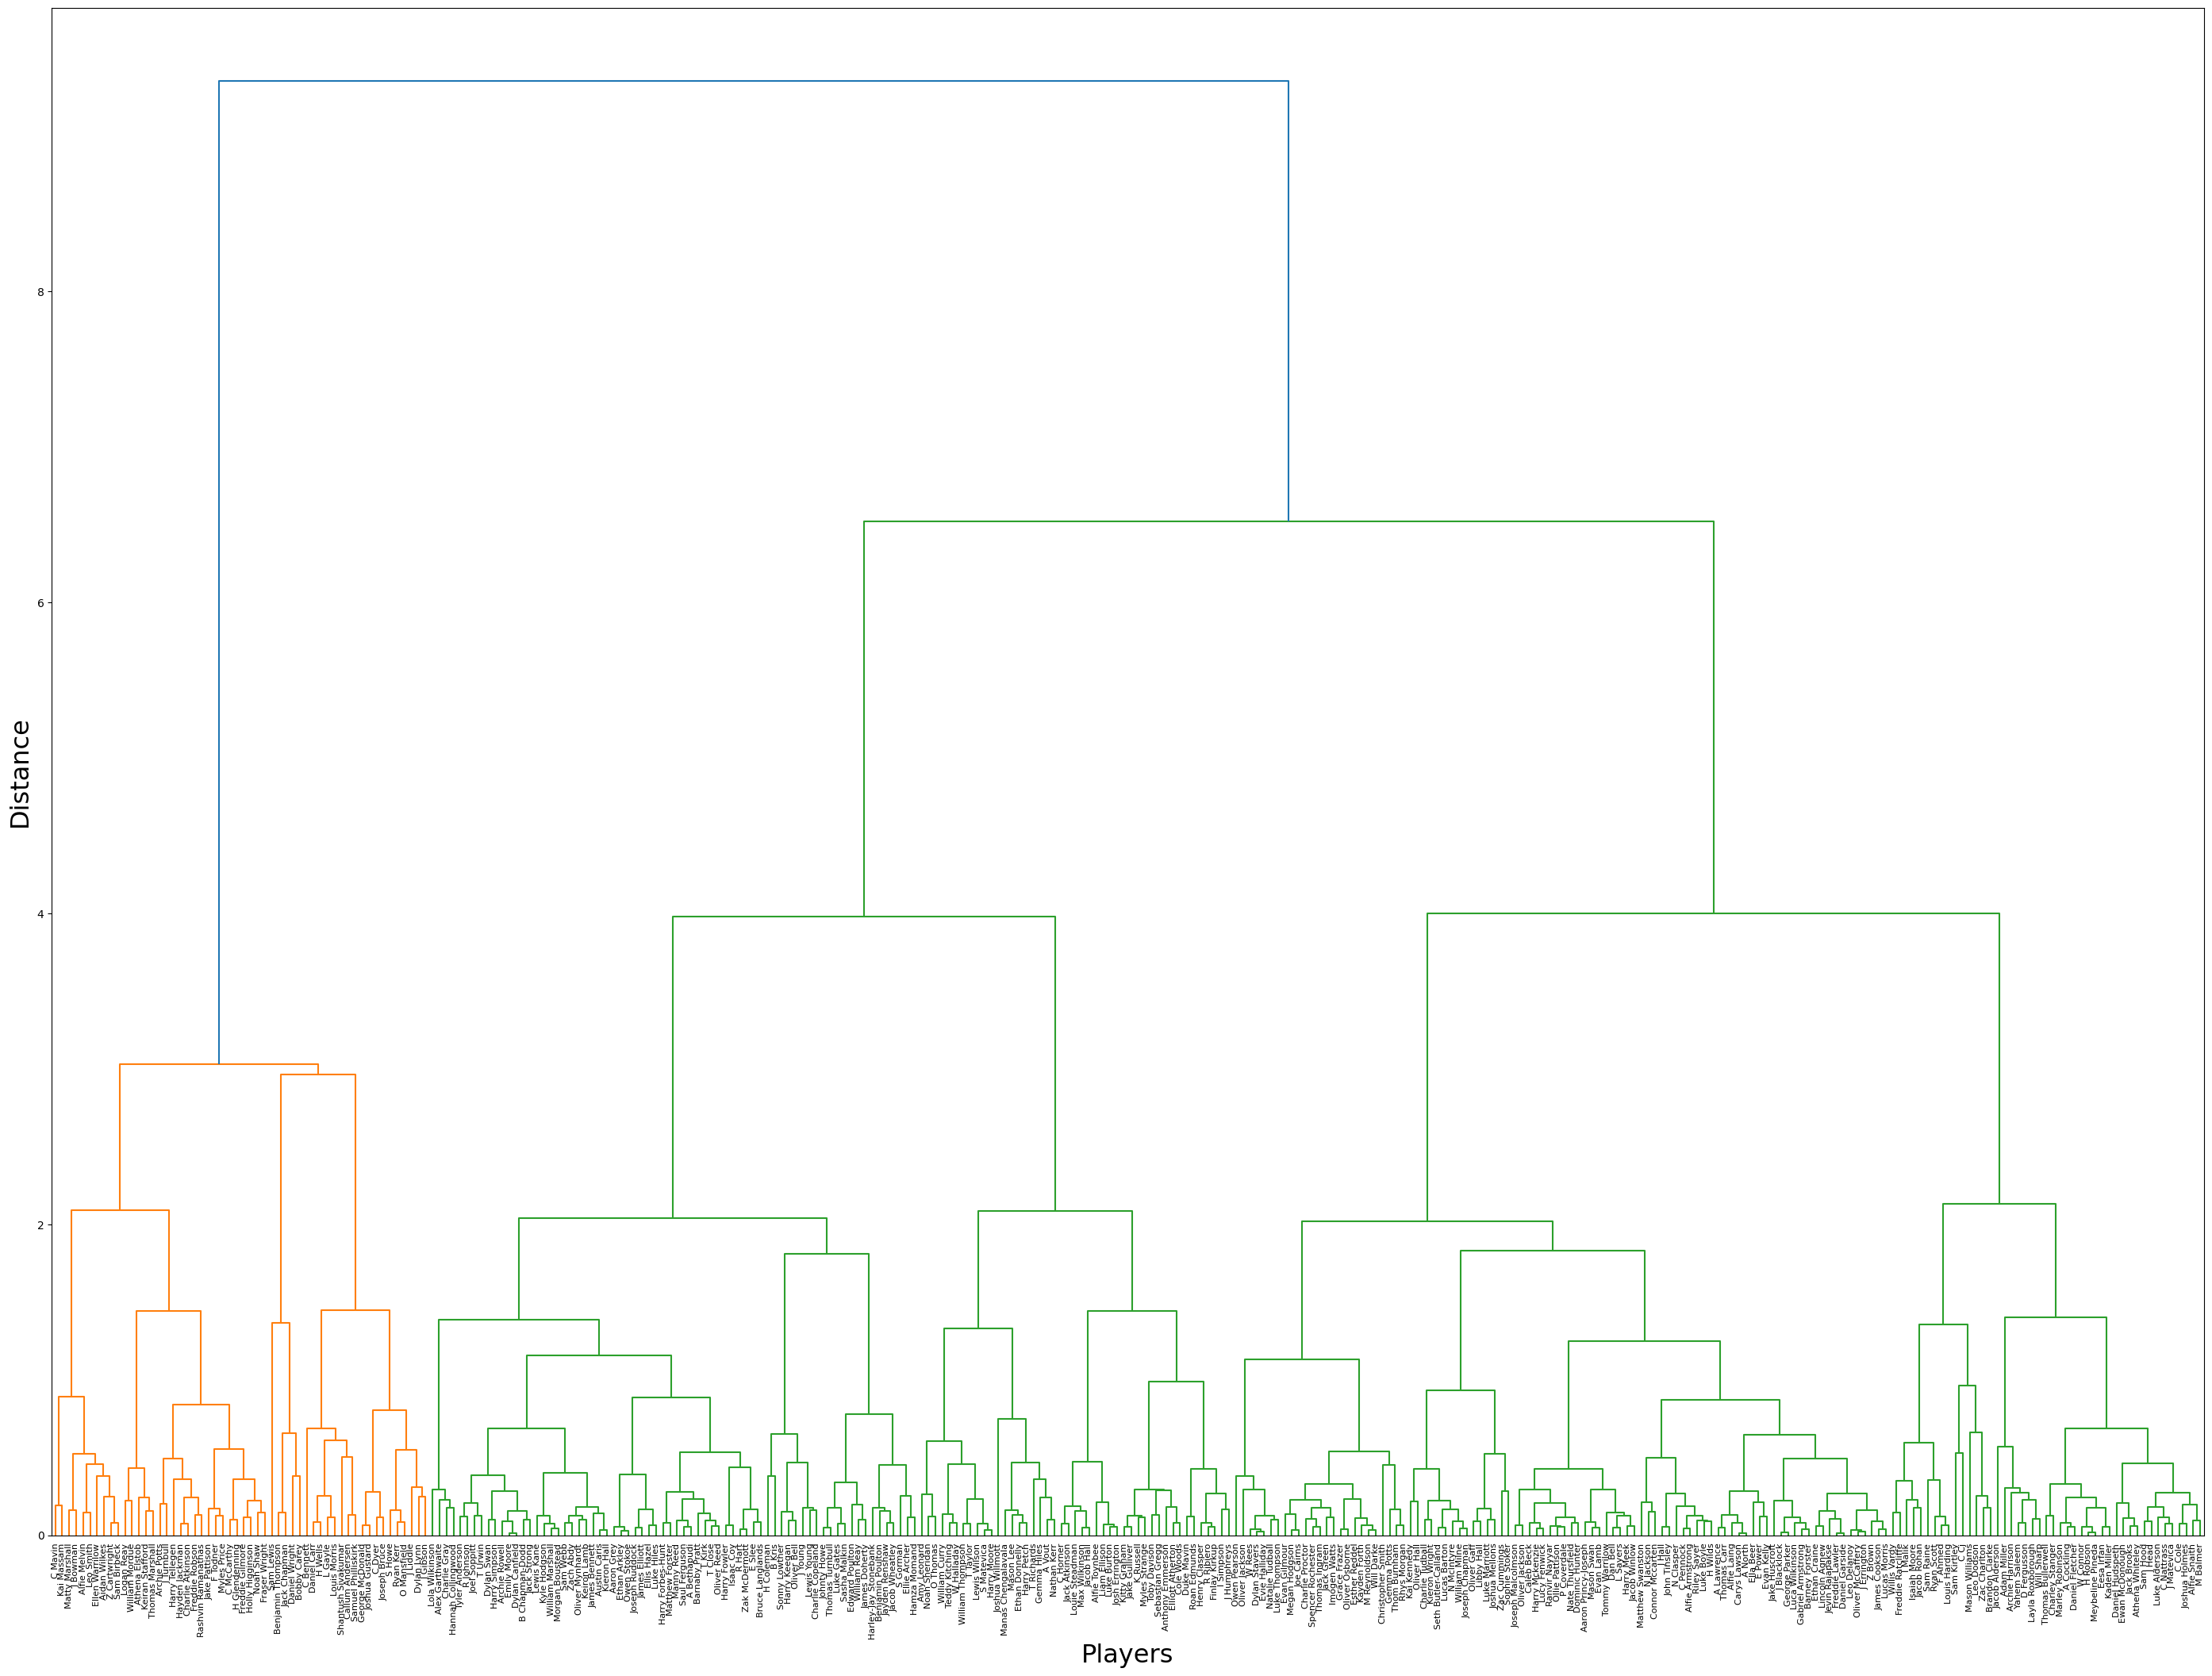

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

h_linkage = linkage(encoded_df.drop('KCluster', axis=1), method='ward')

plt.figure(figsize=(35,25))
dendrogram(h_linkage, labels=df['Player'].values, leaf_rotation=90, leaf_font_size=8)
# plt.title('Hierarchical Clustering Dendrgram', fontsize=25)
plt.xlabel('Players', fontsize=23)
plt.ylabel('Distance', fontsize=23)

plt.show()

In [ ]:
h_labels = fcluster(h_linkage, t=6, criterion='distance')

df['Hcluster'] = h_labels
scaled_df['Hcluster'] = h_labels
encoded_df['Hcluster'] = h_labels


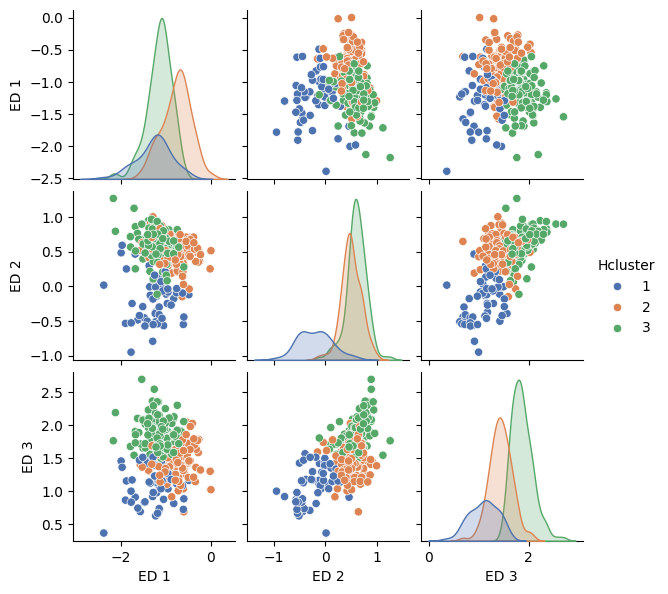

In [ ]:
sns.pairplot(encoded_df.drop('KCluster', axis=1), hue='Hcluster', palette='deep', diag_kind='kde', height=2, aspect=1)
# plt.suptitle('Pairplot of Encoded Dimensions', y=1.02, fontsize=16)
plt.show()


In [ ]:
hcluster_means_summary = scaled_df.drop('KCluster',axis=1).groupby('Hcluster').mean()
hcluster_means_summary.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Bowling Analysis (Ball By Ball)/Analysis (Autoencoders)/Hierarchical (Autoencoder) - Summary.csv')
hcluster_means_summary

,ES,WTS,BBI,CS,BWTS,SPS,DBI,EI,AVMS,BI
Hcluster,,,,,,,,,,
1,0.348949,0.398914,0.498963,0.408373,0.483164,0.377295,0.626162,0.277816,0.515763,0.266821
2,0.533939,0.189227,0.330699,0.512058,0.025669,0.237911,0.462298,0.308969,0.201968,0.436278
3,0.556983,0.191183,0.539930,0.636970,0.021853,0.279471,0.580811,0.484062,0.231525,0.397484


In [ ]:
hcluster_descriptive = scaled_df.drop('KCluster',axis=1).groupby('Hcluster').describe()
hcluster_descriptive.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Bowling Analysis (Ball By Ball)/Analysis (Autoencoders)/Hierarchical (Autoencoder) - Descriptive.csv')
hcluster_descriptive

ES                                                              \
          count      mean       std       min       25%       50%       75%   
Hcluster                                                                      
1          54.0  0.348949  0.129271  0.000000  0.240351  0.360322  0.463937   
2         115.0  0.533939  0.160289  0.217904  0.414713  0.520492  0.640071   
3         139.0  0.556983  0.130102  0.239491  0.474567  0.545717  0.634743   

                      WTS            ...      AVMS               BI            \
               max  count      mean  ...       75%       max  count      mean   
Hcluster                             ...                                        
1         0.601680   54.0  0.398914  ...  0.599617  1.000000   54.0  0.266821   
2         0.916324  115.0  0.189227  ...  0.306172  0.452523  115.0  0.436278   
3         1.000000  139.0  0.191183  ...  0.306835  0.605743  139.0  0.397484   

                                                                      
               std       min       25%       50%       75%       max  
Hcluster                                                              
1         0.134326  0.000000  0.161943  0.292813  0.352119  0.542231  
2         0.211051  0.000000  0.287633  0.405395  0.569166  1.000000  
3         0.151896  0.086245  0.284610  0.379424  0.488883  0.796194  

[3 rows x 80 columns]

In [ ]:
hcluster_1_data = scaled_df[h_labels==1].copy()
hcluster_1_data['Composite Score'] = (
    hcluster_1_data['BBI'] * weights['BBI'] +
    hcluster_1_data['WTS'] * weights['WTS'] +
    hcluster_1_data['CS'] * weights['CS'] +
    hcluster_1_data['EI'] * weights['EI'] +
    hcluster_1_data['DBI'] * weights['DBI'] +
    hcluster_1_data['BWTS'] * weights['BWTS'] +
    hcluster_1_data['SPS'] * weights['SPS'] +
    hcluster_1_data['ES'] * weights['ES'] +
    hcluster_1_data['AVMS'] * weights['AVMS'] +
    hcluster_1_data['BI'] * weights['BI']
)

hcluster_1_data['Bowler'] = df[h_labels==1]['Player'].values
hcluster_1_data['Team'] = df[h_labels==1]['Team'].values

ranked_hcluster = hcluster_1_data[['Bowler', 'Team', 'Composite Score']].sort_values(by='Composite Score', ascending=False)
ranked_hcluster

,Bowler,Team,Composite Score
96,C Bennett,Littletown CC Under 13,5.933566
253,Keiran Stafford,Hylton CCC Under 13,5.457310
191,Athena Elstob,Seaham Harbour CC Under 13 Purple,5.333594
275,Thomas Marshall,Philadelphia CC Under 13,5.213014
49,Dylan Lynn,"Brandon CC, Durham Under 13",5.067583
92,Logan Reay,Eppleton CC Under 13,5.019718
197,S Howe,Seaham Park CC Under 13 B,4.991163
274,J Gibson,Littletown CC Under 13,4.961257
125,Jake Pattison,Seaham Harbour CC Under 13 Yellow,4.705054
220,Alfie Melvin,Greenside CC Under 13,4.659939


In [ ]:
ranked_hcluster['Rank'] = range(1, len(ranked_hcluster) + 1)
ranked_hcluster = ranked_hcluster[['Rank', 'Bowler', 'Team', 'Composite Score']]
ranked_hcluster

,Rank,Bowler,Team,Composite Score
96,1,C Bennett,Littletown CC Under 13,5.933566
253,2,Keiran Stafford,Hylton CCC Under 13,5.457310
191,3,Athena Elstob,Seaham Harbour CC Under 13 Purple,5.333594
275,4,Thomas Marshall,Philadelphia CC Under 13,5.213014
49,5,Dylan Lynn,"Brandon CC, Durham Under 13",5.067583
92,6,Logan Reay,Eppleton CC Under 13,5.019718
197,7,S Howe,Seaham Park CC Under 13 B,4.991163
274,8,J Gibson,Littletown CC Under 13,4.961257
125,9,Jake Pattison,Seaham Harbour CC Under 13 Yellow,4.705054
220,10,Alfie Melvin,Greenside CC Under 13,4.659939


In [ ]:
ranked_hcluster.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Bowling Analysis (Ball By Ball)/Analysis (Autoencoders)/Bowlers Ranked Hierarchical (Autoencoder).csv', index=False)

In [ ]:
scaled_df.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Bowling Analysis (Ball By Ball)/Analysis (Autoencoders)/Bowling Performance Metrics (Ball By Ball) - Scaled with clusters.csv', index=False)
df.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Bowling Analysis (Ball By Ball)/Analysis (Autoencoders)/Bowling Performance Metrics (Ball By Ball) with clusters.csv', index=False)
encoded_df.to_csv('/content/drive/MyDrive/Durham University/Dissertation/Dissertation/Scorecard Analysis v3/Ball By Ball Analysis/Bowling Analysis (Ball By Ball)/Analysis (Autoencoders)/Bowling Performance Metrics (Ball By Ball) - Encoded with clusters.csv', index=False)